In [1]:
from wsidicom import WsiDicom
from tiffslide import TiffSlide
from tiffslide.deepzoom import MinimalComputeAperioDZGenerator
from PIL import Image
import os
import io
os.add_dll_directory(r'C:\tools\openslide-win64-20171122\bin')
from openslide import OpenSlide
from openslide.deepzoom import DeepZoomGenerator
from openslide.lowlevel import _read_region
from ctypes import *

from tifffile import TiffFile
# os.add_dll_directory(r'C:\tools\openslide-win64-20171122\bin')
# from jpegtran import JPEGImage


In [2]:
%load_ext autoreload
%autoreload 2

In [49]:
open_wsi = OpenSlide(r'C:\datasets\AI-DRBR-001\AI-DRBR-001_2523.ndpi')
# for property in open_wsi.properties.items():
#     print(property)
dp = DeepZoomGenerator(open_wsi, tile_size=8, overlap=0, limit_bounds=False)

tile = dp.get_tile(9, (0,0))
dp.get_tile_coordinates(9, (0,0))


def get_encoded_tile(slide, level, x, y, w, h):
    buf = (w * h * c_uint32)()
    _read_region(slide._osr, buf, x, y, level, w, h)
    print(buf)
    return buf

x = 0
y = 0
width = 1024
height = 8
level = 0
tile = get_encoded_tile(open_wsi, x, y, level, width, height)
# Image.open(io.BytesIO(tile))
Image.frombuffer('RGBA', (width, height), tile, 'raw', 'RGBA', 0, 1)



---
TiffPageSeries 0  'Baseline'  86272x126976x3  uint8  YXS  NDPI  5 Levels  1 Pages
TiffPageSeries 0  'Baseline'  86272x126976x3  uint8  YXS  NDPI  5 Levels  1 Pages
TiffPage 0 @1176580748  86272x126976x3  uint8  ycbcr tiled jpeg ndpi
TiffPageSeries 0  21568x31744x3  uint8  YXS  Generic  1 Pages
TiffPage 1 @1277724092  21568x31744x3  uint8  ycbcr tiled jpeg ndpi
TiffPageSeries 0  5392x7936x3  uint8  YXS  Generic  1 Pages
TiffPage 2 @1284946073  5392x7936x3  uint8  ycbcr tiled jpeg ndpi
TiffPageSeries 0  1348x1984x3  uint8  YXS  Generic  1 Pages
TiffPage 3 @1285327817  1348x1984x3  uint8  ycbcr jpeg ndpi
TiffPageSeries 0  337x496x3  uint8  YXS  Generic  1 Pages
TiffPage 4 @1285349505  337x496x3  uint8  ycbcr jpeg ndpi
---
TiffPageSeries 1  'Macro'  409x1197x3  uint8  YXS  NDPI  1 Pages
TiffPageSeries 1  'Macro'  409x1197x3  uint8  YXS  NDPI  1 Pages
TiffPage 5 @1285402208  409x1197x3  uint8  ycbcr jpeg ndpi
---
TiffPageSeries 2  'Map'  204x598  uint8  YX  NDPI  1 Pages  @1285402714
Ti

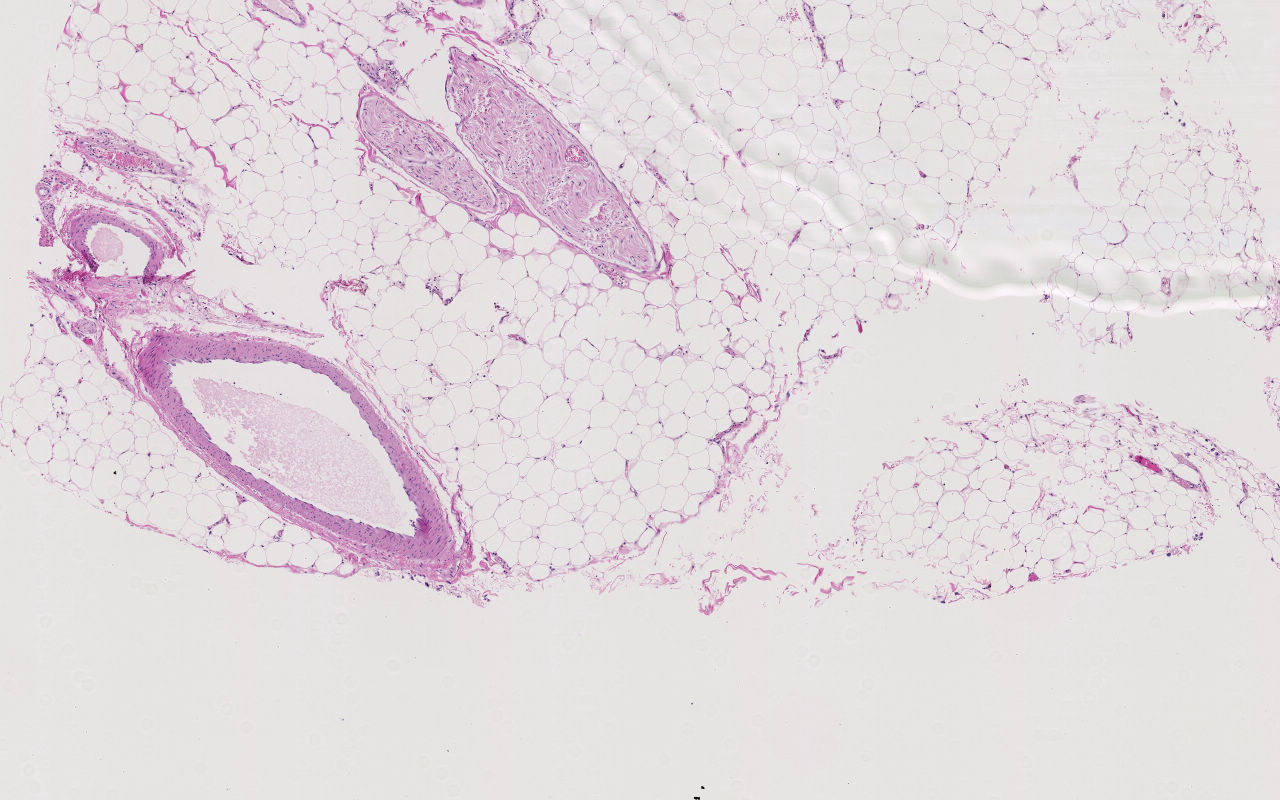

In [9]:
def get_tile_byte_range(page, x, y):
    rows = page.chunked[0]
    cols = page.chunked[1]
    frame = x + y * cols
    offset = page.dataoffsets[frame]
    count = page.databytecounts[frame]
    return (offset, count)

def read_bytes(file, offset, count):
    file.seek(offset)
    data = file.read(count)
    return data


def insert_header(tile_data, header):
    with io.BytesIO() as buffer:
        buffer.write(header)
        buffer.write(tile_data)
        return buffer.getvalue()
    
def get_encoded_tile_from_page(page, fh, x, y):
    offset, count = get_tile_byte_range(page, x, y)
    tile_data = read_bytes(fh, offset, count)
    print(page.jpegheader.hex())
    print(tile_data.hex())

    if page.jpegheader is not None:
        tile_data = insert_header(tile_data, page.jpegheader)
    return tile_data
    
def get_tile_from_page(page, fh, x, y):
    tile_date = get_encoded_tile(page, fh, x, y)
    image=Image.open(io.BytesIO(tile_data))
    return image

def get_encoded_tile(tif, series, level, page, x, y):
    series_ = tif.series[series]
    level_ = series_.levels[level]
    page_ = level_.pages[page]
    return get_encoded_tile_from_page(page_, tif.filehandle, x, y)     

def print_image_info(image):
    print("----------------------------")
    dicts = ['app', 'quantization', 'huffman_dc', 'huffman_ac']
    for dict in dicts:
        print(dict)
        items = getattr(image, dict).items()
        for item in items:
            print(item)   

    lists = ['layer', 'applist', 'icclist']
    for list in lists:
        print(list)
        items = getattr(image, list)
        for item in items:
            print(item)  
            
def stitch_tiles(tif, series, level, page, pos, size):
    tile_width = tif.series[series].levels[level].pages[page].tilewidth
    tile_height = tif.series[series].levels[level].pages[page].tilelength 

    x_write_offset = 0
    y_write_offset = 0
    x_pos = pos[0]
    y_pos = pos[1]
    width = size[0]
    height = size[1]
    image_size = (width*tile_width, height*tile_height)
    image = Image.new(mode='RGB', size=image_size)
    for x in range(x_pos, x_pos+width):
        for y in range(y_pos, y_pos+height):
            tile_data = get_encoded_tile(tif, series, level, page, x, y)
            tile_image=Image.open(io.BytesIO(tile_data))
            image.paste(tile_image, (x_write_offset, y_write_offset))
            y_write_offset += tile_height
        y_write_offset = 0
        x_write_offset += tile_width
    return image

            
with TiffFile(r'C:\datasets\AI-DRBR-001\AI-DRBR-001_2523.ndpi') as tif:
    for series in tif.series:
        print("---")
        print(series)
        for level in series.levels:
            print(level)
            for page in level.pages:
                print(page)
    series = 0
    level = 2
    page = 0
    pos = (2, 100)
    size = (5, 100)
    for level_ in tif.series[series].levels:
        page_ = level_.pages[0]
        print(page_)
        # print(page_.ndpi_tags)
        if page_.is_tiled:
            print(f"tile width {page_.tilewidth} tile height {page_.tilelength}")
        else:
            print("not tiled")
    print(tif.series[series].levels[level])
    image = stitch_tiles(tif, series, level, page, pos, size)
    
image

In [ ]:
from pathlib import Path
from typing import Dict, List, Optional, OrderedDict, Tuple, Union
from wsidicom.geometry import Point, PointMm, Region, RegionMm, Size, SizeMm
import pydicom
from pydicom.uid import UID as Uid
import math
from PIL import Image
import numpy as np


from tiffslide import TiffSlide
from tiffslide.deepzoom import MinimalComputeAperioDZGenerator
from wsidicom import WsiDicom
from wsidicom.interface import WsiGenericInstance, Tiler, TileManager

import io
    
class TiffTiler(Tiler):
    def __init__(self, path, level, level_index):
        self.generator = MinimalComputeAperioDZGenerator(path)
        self.slide = TiffSlide(path)
        self.level = level 
        self.level_index = level_index
        
    def get_encoded_tile(self, tile: Point):
        return self.generator.read_svs_tile(self.level_index, tile.x, tile.y)

class SvsTileManager(TileManager):
    def level_instances(self):
        instances = []
        for i, path in enumerate(self.filepaths):
            slide = TiffSlide(path)
            for level_index, dimension in enumerate(slide.level_dimensions):
                level = int(math.log2(slide.level_downsamples[level_index]))
                image_size = Size.from_tuple(slide.level_dimensions[level_index])
                mpp = slide.properties['aperio.MPP'] * pow(2, level)
                pixel_spacing = SizeMm(mpp*1000.0, mpp*1000.0)
                tile_size = Size(
                    int(slide.properties[f'tiffslide.level[{level_index}].tile-width']),
                    int(slide.properties[f'tiffslide.level[{level_index}].tile-height'])
                )
                instance = WsiGenericInstance(
                    tiler=TiffTiler(path, level, level_index),
                    size=image_size,
                    pixel_spacing=pixel_spacing,
                    tile_size=tile_size,
                    optical_paths=[self.optical_paths[i]],
                    focal_planes=[self.focal_planes[i]],
                    wsi_type='VOLUME',
                    samples_per_pixel=3,
                    transfer_syntax=pydicom.uid.JPEGBaseline8Bit,
                    photometric_interpretation='YBR_FULL_422',
                    slice_thickness=0.0,
                    slice_spacing=0.0
                )
                instances.append(instance)
        return instances
    
class TiffTileManager(TileManager):
    def level_instances(self):
        instances = []
        for i, path in enumerate(self.filepaths):
            slide = TiffSlide(path)
            for level_index, dimension in enumerate(slide.level_dimensions):
                level = int(round(math.log2(slide.level_downsamples[level_index])))
                image_size = Size.from_tuple(slide.level_dimensions[level_index])
                mpp = 0.000243902
                pixel_spacing = SizeMm(mpp, mpp) * pow(2, level)
                tile_size = Size(
                    int(slide.properties[f'tiffslide.level[{level_index}].tile-width']),
                    int(slide.properties[f'tiffslide.level[{level_index}].tile-height'])
                )
                instance = WsiGenericInstance(
                    tiler=TiffTiler(path, level, level_index),
                    size=image_size,
                    pixel_spacing=pixel_spacing,
                    tile_size=tile_size,
                    optical_paths=[self.optical_paths[i]],
                    focal_planes=[self.focal_planes[i]],
                    wsi_type='VOLUME',
                    samples_per_pixel=3,
                    transfer_syntax=pydicom.uid.JPEGBaseline8Bit,
                    photometric_interpretation='YBR_FULL_422',
                    slice_thickness=0.0,
                    slice_spacing=0.0
                )
                instances.append(instance)
        return instances
        
#tile_manager = TiffTileManager([r'c:\slides\Tumor_001.tif'], ['1'], [0.0])
tile_manager = SvsTileManager([r'c:\slides\Leica_1.svs'], ['1'], [0.0])
instances = tile_manager.level_instances()
slide = WsiDicom.open_generic(tile_manager.level_instances(), [], [])

# image = slide.read_thumbnail((512, 512))
#tile = slide.read_tile(3, (0,0), 0, '1')
import time
start = time.time()
slide.save(r'c:\stuffs')

print(time.time()-start)
#tile
# pixels = np.asarray(image)
# completePixelArray = pydicom.pixel_data_handlers.util.convert_color_space(pixels, 'YBR_FULL_422', 'RGB')
# image = Image.fromarray(completePixelArray, 'RGB')

# image

In [ ]:
import io
generator = MinimalComputeAperioDZGenerator(r'c:\slides\Leica_1.svs')
image = Image.open(io.BytesIO(generator.get_tile(8, 0, 0)))
image

In [ ]:
generator.get_dzi()

In [ ]:
tiffslide.properties

In [ ]:
a = [1, 2]
None not in a